# 卷积神经网络（LeNet）

LeNet（LeNet-5）由两个部分组成：
卷积编码器和全连接层密集块
![](./img/Lnext.png)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

检查模型

In [2]:
# 1张28×28的灰度图（随机像素值）；形状：(批量, 通道, 高, 宽) = (1, 1, 28, 28)
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    # 打印层类型名和输出张量形状
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


LeNet在Fashion-MNIST数据集上的表现

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

对
`evaluate_accuracy`函数进行轻微的修改

In [4]:
'''
net: PyTorch模型（nn.Module）
data_iter: 数据迭代器（如DataLoader）
device: 指定设备（GPU/CPU），不指定则自动检测
'''
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 关键：关闭dropout/batchnorm训练行为
        if not device:
            '''
            自动检测：模型在哪个设备，数据就放到哪个设备
            net.parameters()  # 返回模型所有参数的迭代器（权重+偏置）
            iter(net.parameters())  # 将参数迭代器转换为Python迭代器对象
            可迭代对象：像书架（可以放书，但不能直接取下一本）
            迭代器：像书签（可以明确指向下一本书的位置）
            next(iter(net.parameters()))  # 获取迭代器的第一个参数
            第一个参数通常是第一层的权重张量
            '''
            device = next(iter(net.parameters())).device
    '''
    累加器
    2: 存储两个值——正确预测数、总样本数；作用：跨批次累加统计结果
    '''
    metric = d2l.Accumulator(2) 
    with torch.no_grad(): # 禁用梯度计算（推理加速）
        for X, y in data_iter:
            # 处理多输入情况（如X是列表）
            if isinstance(X, list):
                '''
                正常情况：X是单个张量：直接转移即可
                特殊情况：X是列表，需逐个转移
                '''
                X = [x.to(device) for x in X]
            else:
                X = X.to(device) # 将输入数据移到GPU
            y = y.to(device) # 将标签移到GPU
            # 累加：本批次正确数 + 本批次样本数
            metric.add(d2l.accuracy(net(X), y), y.numel())
    # 正确数 / 总数
    return metric[0] / metric[1]

为了使用GPU，我们还需要一点小改动

In [5]:
'''
初始化 → 前向 → 损失 → 反向 → 更新 → 评估

'''
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    '''
    1. 权重初始化
    作用：防止梯度消失/爆炸，加速收敛
    目标：所有卷积层和全连接层的权重
    '''
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier均匀分布初始化
    net.apply(init_weights) # 对网络中每个模块应用此函数
    print('training on', device)
    net.to(device) # 将整个网络移动到GPU/CPU，一次性迁移所有参数和缓冲区
    # 3. 优化器与损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # 随机梯度下降
    loss = nn.CrossEntropyLoss() # 交叉熵损失（内置Softmax）
    # 4. 可视化工具
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    # 5. 训练循环（核心）
    # 外层循环：遍历轮次
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # 累积[总损失, 总正确数, 总样本数]
        net.train() # 关键：设为训练模式（启用Dropout/BN）
        # 内层循环：遍历批次
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad() # 清空过往梯度（关键！否则会累积）
            X, y = X.to(device), y.to(device) # 数据迁移
            # 前向传播
            y_hat = net(X)
            l = loss(y_hat, y) # 计算损失
            # 反向传播
            l.backward() # 计算梯度
            optimizer.step() # 更新参数
            # 统计指标（不计算梯度，节省内存）
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2] # 总损失 / 总样本
            train_acc = metric[1] / metric[2] # 总正确 / 总样本
            '''
            动态更新动画
            触发时机：每完成20%的批次时（// 是整数除法），每轮最后一个批次时（确保每轮结束必然更新）
            '''
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter) # 每轮结束后评估
        animator.add(epoch + 1, (None, None, test_acc)) # 更新测试曲线
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

训练和评估LeNet-5模型

loss 0.465, train acc 0.825, test acc 0.796
31884.2 examples/sec on cuda:0


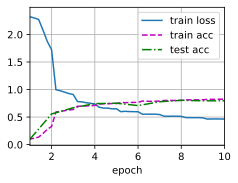

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

第1层输入层： Input为28×28×1<br>
第2层卷积层： Input为28×28×1 ，卷积核5×5 ×1× 6；stride = 1，padding=2。 output为28×28×6<br>
第3层平均池化层： Input为28×28×6，池化感受野为2×2，stride = 2， output为14×14×6<br>
第4层卷积层： Input为14×14×6，卷积核5×5×6 ×16，stride = 1，padding=0, output为10×10×16<br>
第5层平均池化层： Input为10×10×16，池化感受野为2×2 ，stride = 2 , output 为5×5×16，Flatten操作，通过展平得到400个数据与之后的全连接层相连。<br> 
第6～8层全连接层： 第6~8层神经元个数分别为120，84，10。其中神经网络中用sigmoid作为激活函数，最后一层全连接层用softmax输出10个分类。